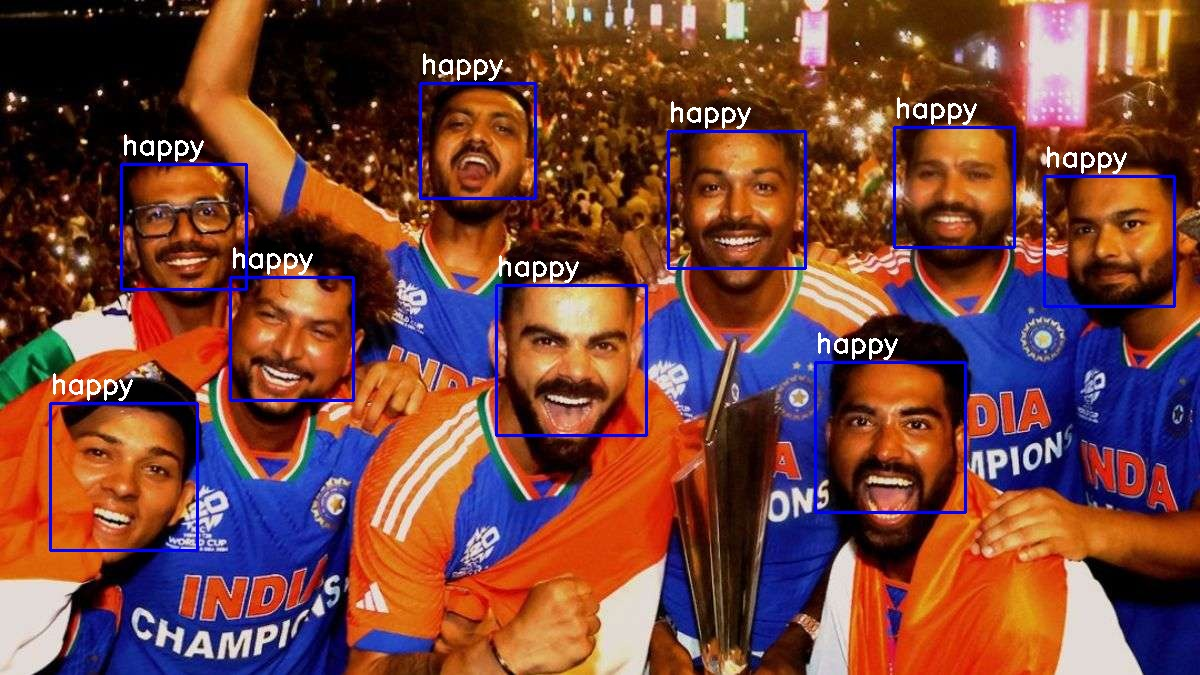

['happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy']
Overall Crowd Sentiment: happy with 9 instances


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

# Function to detect faces based on skin color
def detect_faces_skin_color(image):
    # Convert to YCrCb color space for skin color detection
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define skin color range (in YCrCb) and apply thresholding
    lower_skin = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)

    # Skin color mask
    mask = cv2.inRange(ycrcb_image, lower_skin, upper_skin)

    # Morphological operations to reduce noise
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Detect contours (these will be potential face regions)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    faces = []
    for contour in contours:
        if cv2.contourArea(contour) > 1000:  # Assume a minimum size for a face
            x, y, w, h = cv2.boundingRect(contour)
            faces.append((x, y, w, h))

    return faces

# Function to detect basic hand gestures using contours (simplified approach)
def detect_hand_gestures(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    hand_gestures = []
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter by area size (adjustable)
            x, y, w, h = cv2.boundingRect(contour)
            hand_gestures.append((x, y, w, h))

    return hand_gestures

# Function to extract facial features (eyes, mouth, eyebrows)
def extract_facial_features(image, face):
    x, y, w, h = face
    roi = image[y:y+h, x:x+w]

    # Convert to grayscale for feature detection
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Example basic approach: Look for dark regions for eyes
    eyes = []
    mouth = None
    features = cv2.goodFeaturesToTrack(gray, maxCorners=10, qualityLevel=0.01, minDistance=10)
    features = np.intp(features)  # Fix for the deprecation warning

    for feature in features:
        xf, yf = feature.ravel()
        if yf < h // 3:
            eyes.append((xf + x, yf + y))  # Eyes roughly in upper third of face
        elif yf > 2 * h // 3:
            mouth = (xf + x, yf + y)  # Mouth in lower third

    return eyes, mouth

# Function to classify emotion based on facial geometry
def classify_emotion(eyes, mouth, face):
    if mouth is None:
        return 'Neutral'

    x_mouth, y_mouth = mouth
    x_face, y_face, w_face, h_face = face

    # Simple heuristic: check if mouth is smiling or frowning
    if y_mouth > y_face + 2 * h_face // 3:
        return 'Sad'  # Mouth appears lower, indicating frowning
    else:
        return 'Happy'  # Mouth appears higher, indicating smiling

# Function to estimate sentiments in the crowd
def estimate_crowd_sentiments(image):
    faces = detect_faces_skin_color(image)
    sentiment_results = []

    for face in faces:
        eyes, mouth = extract_facial_features(image, face)
        sentiment = classify_emotion(eyes, mouth, face)
        sentiment_results.append((face, sentiment))  # Return face coordinates with sentiment

    return sentiment_results

# Function to categorize overall image sentiment
def categorize_overall_sentiment(sentiment_results):
    sentiments_count = {'Happy': 0, 'Sad': 0, 'Neutral': 0}

    for _, sentiment in sentiment_results:
        sentiments_count[sentiment] += 1

    majority_sentiment = max(sentiments_count, key=sentiments_count.get)
    return majority_sentiment

# Main function to load image, process and display results
def process_image(image_path):
    image = cv2.imread(image_path)

    sentiment_results = estimate_crowd_sentiments(image)
    overall_sentiment = categorize_overall_sentiment(sentiment_results)

    # Display the results
    for i, (face, sentiment) in enumerate(sentiment_results):
        print("Person {i+1}: {sentiment}")
        x, y, w, h = face
        # Draw bounding box
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # Put sentiment label above the bounding box
        cv2.putText(image, sentiment, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    print(f"Overall Sentiment: {overall_sentiment}")

    # Use cv2_imshow instead of cv2.imshow for Google Colab
    cv2_imshow(image)

# Example usage
image_path = '/content/pexels-photo-8088499.webp'  # Replace with the path to your image
process_image(image_path)